# RESNETXINCEPTION MODEL

Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 526
Inappropriate class size: 510


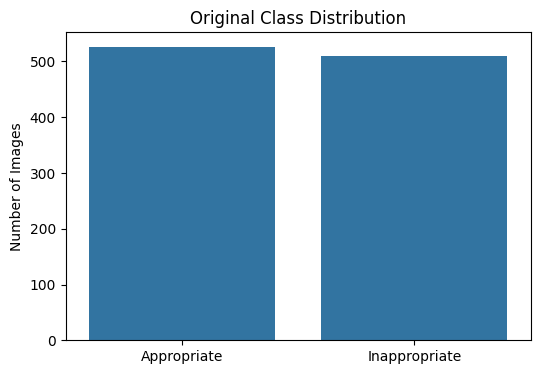

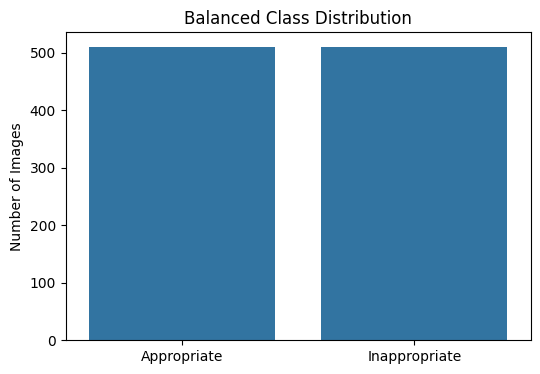

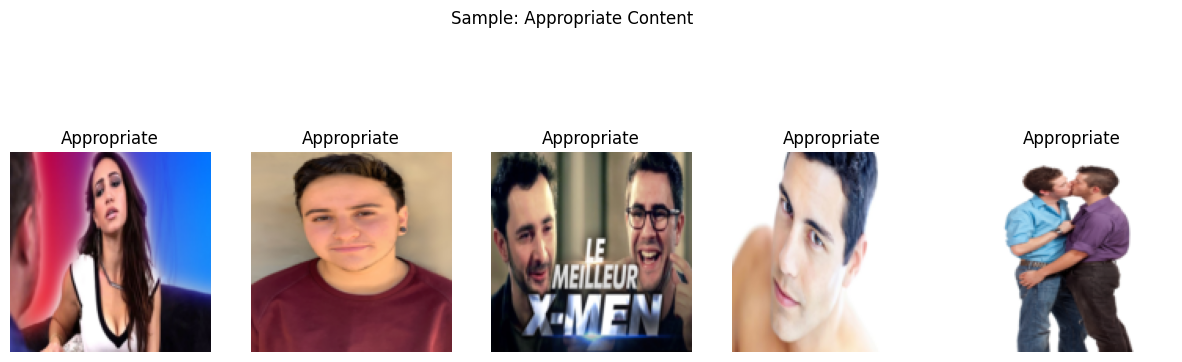

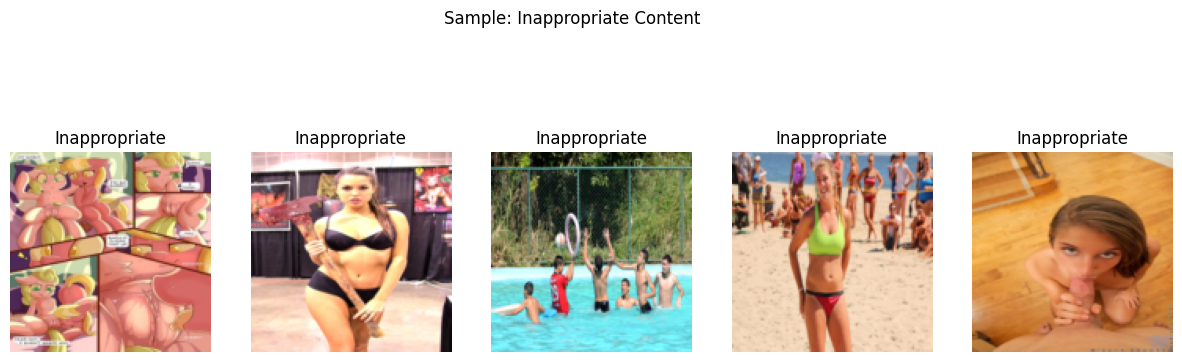

Train set size: 714
Validation set size: 153
Test set size: 153
Train set size: 714
Validation set size: 153
Test set size: 153
Balanced class distribution: 510 appropriate, 510 inappropriate


c:\Users\Carl John\Documents\THESIS - Copy\.venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [15]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random

from sklearn.utils import shuffle


# Dataset path
dataset_path = "./train"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])
# Define transformations
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset with ResNet transformation (for balancing)
dataset_resnet = ImageFolder(dataset_path, transform=transform_resnet)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# 🔹 **Plot original class distribution**
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Undersample the larger class
if len(appropriate_indices) > len(inappropriate_indices):
    appropriate_indices = random.sample(appropriate_indices, len(inappropriate_indices))

# Merge the balanced indices and shuffle
balanced_indices = appropriate_indices + inappropriate_indices
balanced_indices = shuffle(balanced_indices)

# 🔹 **Plot balanced class distribution**
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Balanced Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# 🔹 **Display sample images**
show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")
# Create balanced datasets
### BALANCED DATASET RESNET AND INCEPTION VARIABLES ARE NOT USED SO I COMMENTED THEM OUT
# balanced_dataset_resnet = Subset(dataset_resnet, balanced_indices)
dataset_inception = ImageFolder(dataset_path, transform=transform_inception)
# balanced_dataset_inception = Subset(dataset_inception, balanced_indices)

# # Train-test split
# train_idx, val_idx = train_test_split(balanced_indices, test_size=0.2, random_state=42)

# train_resnet = Subset(dataset_resnet, train_idx)
# val_resnet = Subset(dataset_resnet, val_idx)

# train_inception = Subset(dataset_inception, train_idx)
# val_inception = Subset(dataset_inception, val_idx)

# # Data Loaders
# train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
# val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False)

# train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)
# val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False)




# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size  # Ensure total length matches

train_idx, val_idx, test_idx = random_split(balanced_indices, [train_size, val_size, test_size])

# Create subsets for ResNet
train_resnet = Subset(dataset_resnet, train_idx)
val_resnet = Subset(dataset_resnet, val_idx)
test_resnet = Subset(dataset_resnet, test_idx)


# Create subsets for Inception (using the same indices)
train_inception = Subset(dataset_inception, train_idx)
val_inception = Subset(dataset_inception, val_idx)
test_inception = Subset(dataset_inception, test_idx)

train_loader_resnet = DataLoader(train_resnet, batch_size=32, shuffle=True)
val_loader_resnet = DataLoader(val_resnet, batch_size=32, shuffle=False)
test_loader_resnet = DataLoader(test_resnet, batch_size=32, shuffle=False)

train_loader_inception = DataLoader(train_inception, batch_size=32, shuffle=True)
val_loader_inception = DataLoader(val_inception, batch_size=32, shuffle=False)
test_loader_inception = DataLoader(test_inception, batch_size=32, shuffle=False)

print(f"Train set size: {len(train_resnet)}")
print(f"Validation set size: {len(val_resnet)}")
print(f"Test set size: {len(test_resnet)}")

print(f"Train set size: {len(train_inception)}")
print(f"Validation set size: {len(val_inception)}")
print(f"Test set size: {len(test_inception)}")




# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")

# Define the model
class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super(FusionModel, self).__init__()
        
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)
        
        # Step 1: Freeze All Layers Initially**
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.inception.parameters():
            param.requires_grad = False
        
        # for param in self.resnet.fc.parameters():
        #       param.requires_grad = True
        # for param in self.inception.fc.parameters():
        #       param.requires_grad = True    
              
        self.resnet.fc = nn.Identity()
        self.inception.fc = nn.Identity()
        
        self.batch_norm = nn.BatchNorm1d(4096)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.55)
        self.fc = nn.Linear(4096, 1)
        
    def forward(self, x_resnet, x_inception):
        resnet_features = self.resnet(x_resnet)
        inception_features = self.inception(x_inception)
        if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
            inception_features = inception_features[0]  # Take only the main output
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
        fused_features = self.batch_norm(fused_features)
        fused_features = self.relu(fused_features)
        fused_features = self.dropout(fused_features)
        # output = torch.sigmoid(self.fc(fused_features))
        output = self.fc(fused_features)  # No sigmoid here

        return output

# Initialize model
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()  # Use this instead of BCELoss() para may SIGMOID ACTIVATION INSIDE
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
from torchinfo import summary
from torchvision.models import inception_v3


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

ModuleNotFoundError: No module named 'torchinfo'

In [19]:

def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
    
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## First Training

In [7]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
   
    
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

       
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, _ = inception_batch
            
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
   
    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


history, metrics = train_model(model, train_loader_resnet, train_loader_inception, 
                      val_loader_resnet, val_loader_inception, 
                      criterion, optimizer, epochs=5 )

# # Evaluation
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(test_loader_resnet, test_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to("cuda"), x_inception.to("cuda"), y.to("cuda").float()
        outputs = model(x_resnet, x_inception).squeeze()
        # preds = (outputs > 0.5).cpu().numpy()
        # y_true.extend(y.cpu().numpy())
        # y_pred.extend(preds)
        # Convert probabilities to binary predictions
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
        
# print(classification_report(y_true, y_pred))
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

# Generate classification report
# report = classification_report(y_true, y_pred)


# Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")




report = classification_report(y_true, y_pred, target_names=["Appropriate", "Inappropriate"])

# Save classification report to a file
with open("training_history/first_classification_reportv4.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 
# Optionally, print to console as well

print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

Epoch 1/5: 100%|██████████| 454/454 [14:45<00:00,  1.95s/it, accuracy=82.9, loss=0.413]



Epoch 1/5: Train Loss = 0.3655, Train Accuracy = 82.95%
Validation Loss = 0.2478, Validation Accuracy = 88.87%



Epoch 2/5: 100%|██████████| 454/454 [07:44<00:00,  1.02s/it, accuracy=85.2, loss=0.369] 



Epoch 2/5: Train Loss = 0.3435, Train Accuracy = 85.19%
Validation Loss = 0.2593, Validation Accuracy = 87.20%



Epoch 3/5: 100%|██████████| 454/454 [07:43<00:00,  1.02s/it, accuracy=85.1, loss=0.241] 



Epoch 3/5: Train Loss = 0.3500, Train Accuracy = 85.09%
Validation Loss = 0.2512, Validation Accuracy = 89.20%



Epoch 4/5: 100%|██████████| 454/454 [07:42<00:00,  1.02s/it, accuracy=85.1, loss=0.25]  



Epoch 4/5: Train Loss = 0.3532, Train Accuracy = 85.14%
Validation Loss = 0.2466, Validation Accuracy = 87.68%



Epoch 5/5: 100%|██████████| 454/454 [07:44<00:00,  1.02s/it, accuracy=84.9, loss=0.436] 



Epoch 5/5: Train Loss = 0.3573, Train Accuracy = 84.88%
Validation Loss = 0.2392, Validation Accuracy = 89.45%

Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0764
False Negative Rate (FNR): 0.1337
AUC-ROC Score: 0.9656
TN: 1415, FP: 117, FN: 211, TP: 1367

Test Set Metrics:
False Positive Rate (FPR): 0.0834
False Negative Rate (FNR): 0.1299
AUC-ROC Score: 0.9655
Confusion Matrix:
[[1461  133]
 [ 197 1320]]
               precision    recall  f1-score   support

  Appropriate       0.88      0.92      0.90      1594
Inappropriate       0.91      0.87      0.89      1517

     accuracy                           0.89      3111
    macro avg       0.89      0.89      0.89      3111
 weighted avg       0.89      0.89      0.89      3111

Accuracy Score: 0.8939247830279653


In [8]:
with open("training_history/first_classification_reportv4.txt", "r") as file:
    report = file.read()

print(report)

               precision    recall  f1-score   support

  Appropriate       0.88      0.92      0.90      1594
Inappropriate       0.91      0.87      0.89      1517

     accuracy                           0.89      3111
    macro avg       0.89      0.89      0.89      3111
 weighted avg       0.89      0.89      0.89      3111

Accuracy Score: 0.8939247830279653



save training history

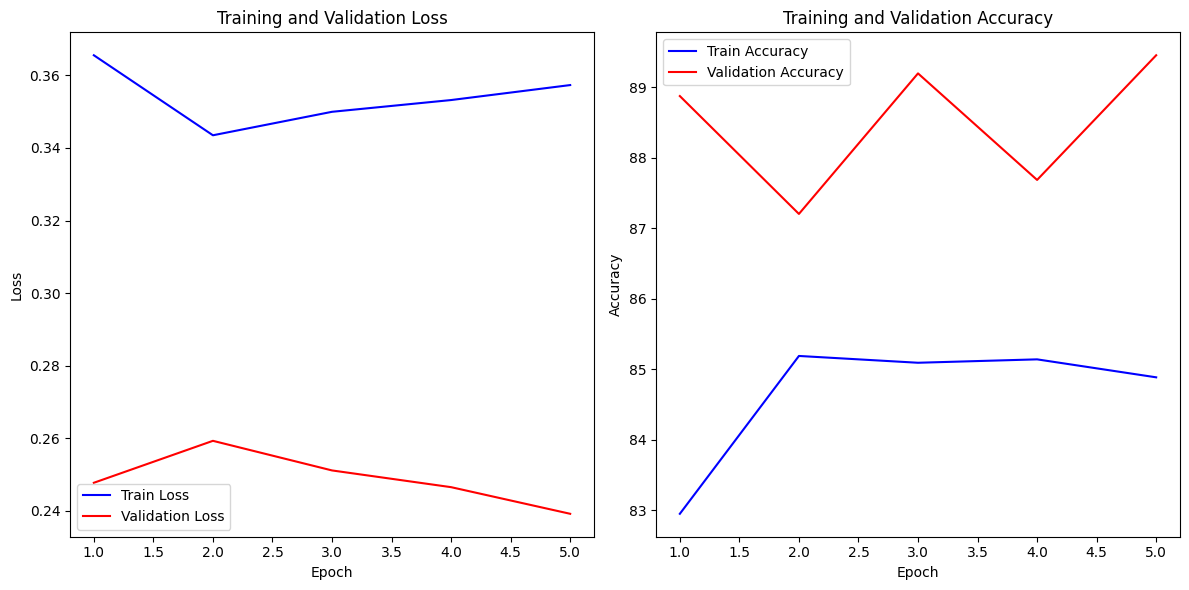

In [9]:
plot_from_history(history)

In [10]:
df = pd.DataFrame(history)
df.to_csv('training_history/first_training_historyv4.csv', index=False)

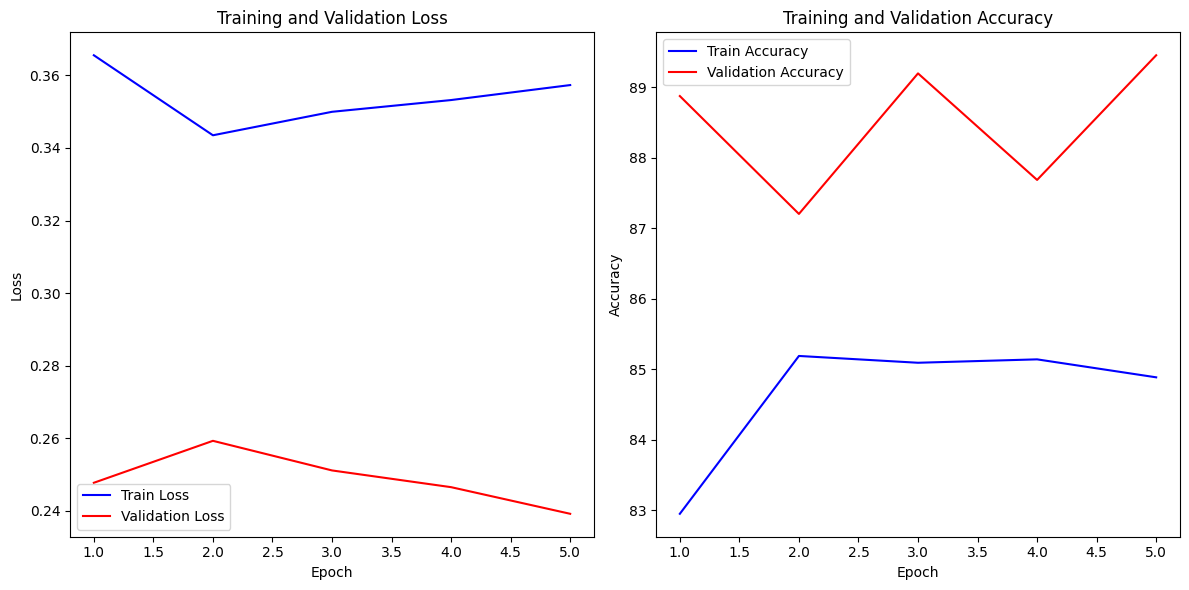

In [11]:
history_df = pd.read_csv('training_history/first_training_historyv4.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

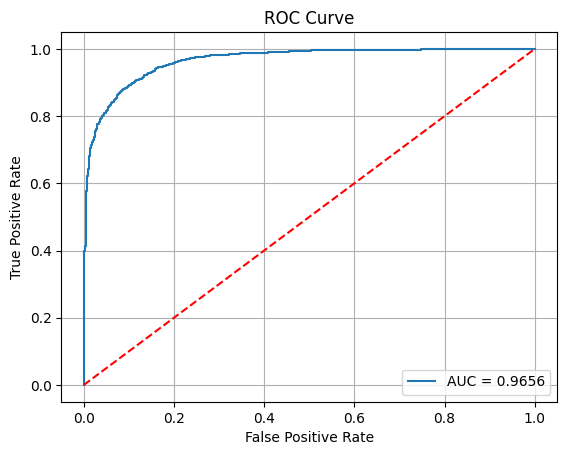

In [12]:
import pandas as pd

# Flatten data for CSV saving
metrics_flat = {
    "class_names": metrics["class_names"],
    "fpr": metrics["fpr"],
    "fnr": metrics["fnr"],
    "auc_roc": metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in metrics["confusion_matrix"]]
}
plot_roc_curve(metrics_flat)


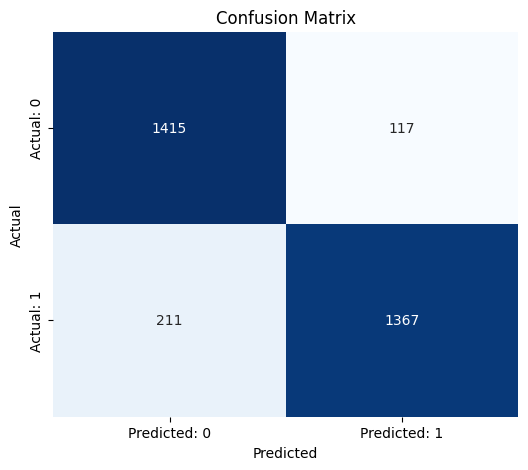

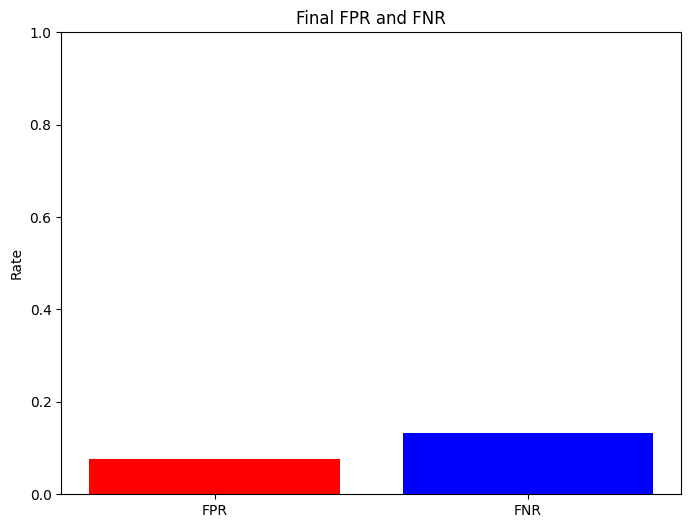

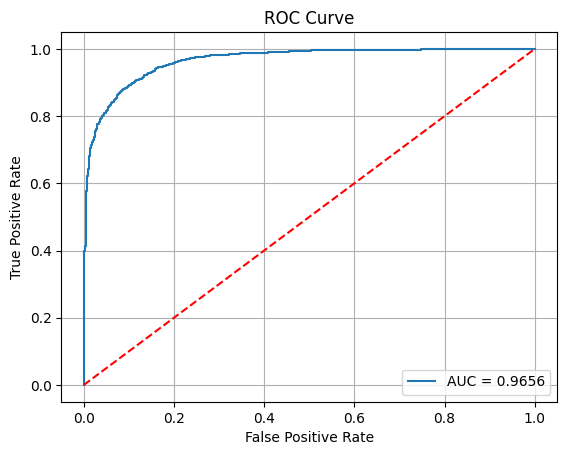

In [13]:

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_flat)

metrics_df.to_csv('training_history/first_training_metricsv4.csv', index=False)


# Load the CSV file containing the final metrics
metrics_df = pd.read_csv('training_history/first_training_metricsv4.csv')

# Extract individual metrics
auc_score = metrics_df['auc_roc'][0]
fpr = metrics_df['fpr'][0]
fnr = metrics_df['fnr'][0]

# Extract confusion matrix (flattened form)
conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
tn, fp, fn, tp = conf_matrix

# Extract ROC curve data (flattened form)
roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
# Confusion Matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot FPR and FNR
plt.figure(figsize=(8, 6))
plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
plt.ylabel('Rate')
plt.title('Final FPR and FNR')
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


## Second Training - Unfreeze layers for fine tuning

In [14]:
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR

# Unfreeze the last 50 layers of Inception and the last 94 layers of ResNet
# for param in list(model.inception.parameters())[-132:]:
#     param.requires_grad = True
# for param in list(model.resnet.parameters())[-75:]:
#     param.requires_grad = True

 
for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
# Unfreezing the last few Inception blocks
for param in model.inception.Mixed_7c.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_7b.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_7a.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_6e.parameters():
    param.requires_grad = True

for param in model.inception.Mixed_6d.parameters():
    param.requires_grad = True

# # Reset optimizer with a lower learning rate
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
# print(model)
# # summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


# Hyperparameter tuning example
# learning_rates = [0.0001, 0.0005]
# batch_sizes = [32, 64]
# best_accuracy = 0.0
# best_params = {}
# try:
#     for lr in learning_rates:
#         for batch_size in batch_sizes:
#             # Set optimizer
#             optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

#             # Set DataLoader
#             train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
#             train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

#             # Training loop with scheduler
#             scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

#             # Train the model
#             secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
#                                                     val_loader_resnet, val_loader_inception, 
#                                                     criterion, optimizer, epochs=5)

#             # Check performance
#             average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])
#             if average_accuracy > best_accuracy:
#                 best_accuracy = average_accuracy
#                 best_params = {'lr': lr, 'batch_size': batch_size}

#             scheduler.step()
# except Exception as e:
#     print(f"Error occurred: {e}, but training will continue with the next parameters.")
    
# print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")

resnet.conv1.weight: Frozen
resnet.bn1.weight: Frozen
resnet.bn1.bias: Frozen
resnet.layer1.0.conv1.weight: Frozen
resnet.layer1.0.bn1.weight: Frozen
resnet.layer1.0.bn1.bias: Frozen
resnet.layer1.0.conv2.weight: Frozen
resnet.layer1.0.bn2.weight: Frozen
resnet.layer1.0.bn2.bias: Frozen
resnet.layer1.0.conv3.weight: Frozen
resnet.layer1.0.bn3.weight: Frozen
resnet.layer1.0.bn3.bias: Frozen
resnet.layer1.0.downsample.0.weight: Frozen
resnet.layer1.0.downsample.1.weight: Frozen
resnet.layer1.0.downsample.1.bias: Frozen
resnet.layer1.1.conv1.weight: Frozen
resnet.layer1.1.bn1.weight: Frozen
resnet.layer1.1.bn1.bias: Frozen
resnet.layer1.1.conv2.weight: Frozen
resnet.layer1.1.bn2.weight: Frozen
resnet.layer1.1.bn2.bias: Frozen
resnet.layer1.1.conv3.weight: Frozen
resnet.layer1.1.bn3.weight: Frozen
resnet.layer1.1.bn3.bias: Frozen
resnet.layer1.2.conv1.weight: Frozen
resnet.layer1.2.bn1.weight: Frozen
resnet.layer1.2.bn1.bias: Frozen
resnet.layer1.2.conv2.weight: Frozen
resnet.layer1.2.bn2.

## PARAM TUNING WITH DECAYING LR


In [13]:
# Define hyperparameter search space
learning_rates = [0.0005 , 0.0009]
batch_sizes = [32, 64]
best_accuracy = 0.0
best_params = {}


for lr in learning_rates:
    for batch_size in batch_sizes:
            # Set optimizer
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

            # Set DataLoaders
            train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
            train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

            # Use CosineAnnealingLR
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
            secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

            # Check performance
            average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])

            if average_accuracy > best_accuracy:
                best_accuracy = average_accuracy
                best_params = {'lr': lr, 'batch_size': batch_size}



print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")


Epoch 1/5: 100%|██████████| 519/519 [15:06<00:00,  1.75s/it, accuracy=49.9, loss=58.3]



Epoch 1/5: Train Loss = 50.0674, Train Accuracy = 49.89%
Validation Loss = 49.3077, Validation Accuracy = 50.65%

Before Step Learning Rate: 0.0005
Current Learning Rate: 0.00045320916362186214


Epoch 2/5: 100%|██████████| 519/519 [14:30<00:00,  1.68s/it, accuracy=82.9, loss=0.199]



Epoch 2/5: Train Loss = 0.4463, Train Accuracy = 82.95%
Validation Loss = 0.2575, Validation Accuracy = 89.39%

Before Step Learning Rate: 0.00045320916362186214
Current Learning Rate: 0.00033070916362186215


Epoch 3/5: 100%|██████████| 519/519 [13:16<00:00,  1.54s/it, accuracy=89.6, loss=1.31]  



Epoch 3/5: Train Loss = 0.2553, Train Accuracy = 89.58%
Validation Loss = 0.2046, Validation Accuracy = 91.51%

Before Step Learning Rate: 0.00033070916362186215
Current Learning Rate: 0.0001792908363781379


Epoch 4/5: 100%|██████████| 519/519 [12:54<00:00,  1.49s/it, accuracy=92.8, loss=0.143] 



Epoch 4/5: Train Loss = 0.1780, Train Accuracy = 92.80%
Validation Loss = 0.1885, Validation Accuracy = 92.09%

Before Step Learning Rate: 0.0001792908363781379
Current Learning Rate: 5.67908363781379e-05


Epoch 5/5: 100%|██████████| 519/519 [12:54<00:00,  1.49s/it, accuracy=96, loss=2.53]    



Epoch 5/5: Train Loss = 0.1075, Train Accuracy = 96.00%
Validation Loss = 0.1524, Validation Accuracy = 93.68%

Before Step Learning Rate: 5.67908363781379e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0909
False Negative Rate (FNR): 0.0347
AUC-ROC Score: 0.9882
TN: 1910, FP: 191, FN: 71, TP: 1976


Epoch 1/5: 100%|██████████| 260/260 [23:11<00:00,  5.35s/it, accuracy=95.2, loss=0.58]  



Epoch 1/5: Train Loss = 0.1299, Train Accuracy = 95.22%
Validation Loss = 0.3314, Validation Accuracy = 88.65%

Before Step Learning Rate: 0.0005
Current Learning Rate: 0.00045320916362186214


Epoch 2/5: 100%|██████████| 260/260 [24:41<00:00,  5.70s/it, accuracy=96.9, loss=0.414]  



Epoch 2/5: Train Loss = 0.0818, Train Accuracy = 96.92%
Validation Loss = 0.2408, Validation Accuracy = 92.33%

Before Step Learning Rate: 0.00045320916362186214
Current Learning Rate: 0.00033070916362186215


Epoch 3/5: 100%|██████████| 260/260 [24:33<00:00,  5.67s/it, accuracy=98.2, loss=0.00554]



Epoch 3/5: Train Loss = 0.0479, Train Accuracy = 98.22%
Validation Loss = 0.2561, Validation Accuracy = 93.97%

Before Step Learning Rate: 0.00033070916362186215
Current Learning Rate: 0.0001792908363781379


Epoch 4/5: 100%|██████████| 260/260 [24:25<00:00,  5.64s/it, accuracy=99.6, loss=0.000176]



Epoch 4/5: Train Loss = 0.0122, Train Accuracy = 99.64%
Validation Loss = 0.2002, Validation Accuracy = 94.41%

Before Step Learning Rate: 0.0001792908363781379
Current Learning Rate: 5.67908363781379e-05


Epoch 5/5: 100%|██████████| 260/260 [24:10<00:00,  5.58s/it, accuracy=99.8, loss=3.24e-5] 



Epoch 5/5: Train Loss = 0.0066, Train Accuracy = 99.82%
Validation Loss = 0.1602, Validation Accuracy = 94.91%

Before Step Learning Rate: 5.67908363781379e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0571
False Negative Rate (FNR): 0.0445
AUC-ROC Score: 0.9912
TN: 1981, FP: 120, FN: 91, TP: 1956


Epoch 1/5: 100%|██████████| 519/519 [12:30<00:00,  1.45s/it, accuracy=93.8, loss=0.0353]



Epoch 1/5: Train Loss = 0.1790, Train Accuracy = 93.78%
Validation Loss = 0.2458, Validation Accuracy = 91.13%

Before Step Learning Rate: 0.0009
Current Learning Rate: 0.0008150125624968516


Epoch 2/5: 100%|██████████| 519/519 [4:15:10<00:00, 29.50s/it, accuracy=95.3, loss=0.015]       



Epoch 2/5: Train Loss = 0.1472, Train Accuracy = 95.29%
Validation Loss = 0.2259, Validation Accuracy = 91.97%

Before Step Learning Rate: 0.0008150125624968516
Current Learning Rate: 0.0005925125624968515


Epoch 3/5: 100%|██████████| 519/519 [14:33<00:00,  1.68s/it, accuracy=97, loss=0.034]    



Epoch 3/5: Train Loss = 0.1032, Train Accuracy = 96.99%
Validation Loss = 0.2781, Validation Accuracy = 92.02%

Before Step Learning Rate: 0.0005925125624968515
Current Learning Rate: 0.0003174874375031484


Epoch 4/5: 100%|██████████| 519/519 [13:04<00:00,  1.51s/it, accuracy=98.8, loss=0.00203] 



Epoch 4/5: Train Loss = 0.0319, Train Accuracy = 98.82%
Validation Loss = 0.3505, Validation Accuracy = 91.80%

Before Step Learning Rate: 0.0003174874375031484
Current Learning Rate: 9.49874375031484e-05


Epoch 5/5: 100%|██████████| 519/519 [12:49<00:00,  1.48s/it, accuracy=99.6, loss=0.000661]



Epoch 5/5: Train Loss = 0.0126, Train Accuracy = 99.59%
Validation Loss = 0.1839, Validation Accuracy = 94.24%

Before Step Learning Rate: 9.49874375031484e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0809
False Negative Rate (FNR): 0.0337
AUC-ROC Score: 0.9904
TN: 1931, FP: 170, FN: 69, TP: 1978


Epoch 1/5: 100%|██████████| 260/260 [25:03<00:00,  5.78s/it, accuracy=98.3, loss=0.0811]  



Epoch 1/5: Train Loss = 0.0525, Train Accuracy = 98.25%
Validation Loss = 0.6643, Validation Accuracy = 91.80%

Before Step Learning Rate: 0.0009
Current Learning Rate: 0.0008150125624968516


Epoch 2/5: 100%|██████████| 260/260 [25:58<00:00,  5.99s/it, accuracy=98.2, loss=0.523]   



Epoch 2/5: Train Loss = 0.0546, Train Accuracy = 98.23%
Validation Loss = 0.4270, Validation Accuracy = 92.36%

Before Step Learning Rate: 0.0008150125624968516
Current Learning Rate: 0.0005925125624968515


Epoch 3/5: 100%|██████████| 260/260 [26:39<00:00,  6.15s/it, accuracy=99.3, loss=0.000338]



Epoch 3/5: Train Loss = 0.0203, Train Accuracy = 99.30%
Validation Loss = 0.2748, Validation Accuracy = 93.37%

Before Step Learning Rate: 0.0005925125624968515
Current Learning Rate: 0.0003174874375031484


Epoch 4/5: 100%|██████████| 260/260 [25:09<00:00,  5.81s/it, accuracy=99.7, loss=6.46e-6] 



Epoch 4/5: Train Loss = 0.0118, Train Accuracy = 99.72%
Validation Loss = 0.2534, Validation Accuracy = 94.58%

Before Step Learning Rate: 0.0003174874375031484
Current Learning Rate: 9.49874375031484e-05


Epoch 5/5: 100%|██████████| 260/260 [25:20<00:00,  5.85s/it, accuracy=99.9, loss=0.00158] 



Epoch 5/5: Train Loss = 0.0034, Train Accuracy = 99.90%
Validation Loss = 0.2394, Validation Accuracy = 95.25%

Before Step Learning Rate: 9.49874375031484e-05
Current Learning Rate: 1e-05
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0438
False Negative Rate (FNR): 0.0513
AUC-ROC Score: 0.9901
TN: 2009, FP: 92, FN: 105, TP: 1942
Best Hyperparameters: {'lr': 0.0009, 'batch_size': 64}, Best Accuracy: 93.47155255544843


In [14]:
# Extract best hyperparameters
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Print to verify
print(f"Using Best Hyperparameters -> Learning Rate: {best_lr}, Batch Size: {best_batch_size}")

Using Best Hyperparameters -> Learning Rate: 0.0009, Batch Size: 64


In [15]:

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003)

            # Set DataLoaders
train_loader_resnet = DataLoader(train_resnet, batch_size=64, shuffle=True)
train_loader_inception = DataLoader(train_inception, batch_size=64, shuffle=True)

            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=10, scheduler=scheduler)

Epoch 1/10: 100%|██████████| 227/227 [12:10<00:00,  3.22s/it, accuracy=75.2, loss=0.195]



Epoch 1/10: Train Loss = 0.6110, Train Accuracy = 75.18%
Validation Loss = 0.3185, Validation Accuracy = 85.98%

Before Step Learning Rate: 0.0003
Current Learning Rate: 0.0002723074641843674


Epoch 2/10: 100%|██████████| 227/227 [12:33<00:00,  3.32s/it, accuracy=88.5, loss=0.188] 



Epoch 2/10: Train Loss = 0.2883, Train Accuracy = 88.53%
Validation Loss = 0.1623, Validation Accuracy = 92.80%

Before Step Learning Rate: 0.0002723074641843674
Current Learning Rate: 0.00019980746418436736


Epoch 3/10: 100%|██████████| 227/227 [12:27<00:00,  3.29s/it, accuracy=96.3, loss=0.108] 



Epoch 3/10: Train Loss = 0.0961, Train Accuracy = 96.30%
Validation Loss = 0.1133, Validation Accuracy = 95.14%

Before Step Learning Rate: 0.00019980746418436736
Current Learning Rate: 0.00011019253581563262


Epoch 4/10: 100%|██████████| 227/227 [12:28<00:00,  3.30s/it, accuracy=98.9, loss=0.003]  



Epoch 4/10: Train Loss = 0.0315, Train Accuracy = 98.91%
Validation Loss = 0.0857, Validation Accuracy = 96.72%

Before Step Learning Rate: 0.00011019253581563262
Current Learning Rate: 3.769253581563263e-05


Epoch 5/10: 100%|██████████| 227/227 [12:31<00:00,  3.31s/it, accuracy=99.8, loss=0.00658] 



Epoch 5/10: Train Loss = 0.0081, Train Accuracy = 99.80%
Validation Loss = 0.0683, Validation Accuracy = 97.49%

Before Step Learning Rate: 3.769253581563263e-05
Current Learning Rate: 1e-05


Epoch 6/10: 100%|██████████| 227/227 [12:34<00:00,  3.32s/it, accuracy=99.8, loss=0.00298] 



Epoch 6/10: Train Loss = 0.0048, Train Accuracy = 99.85%
Validation Loss = 0.0668, Validation Accuracy = 97.59%

Before Step Learning Rate: 1e-05
Current Learning Rate: 3.769253581563262e-05


Epoch 7/10: 100%|██████████| 227/227 [12:23<00:00,  3.28s/it, accuracy=100, loss=0.0168]   



Epoch 7/10: Train Loss = 0.0029, Train Accuracy = 99.95%
Validation Loss = 0.0703, Validation Accuracy = 97.65%

Before Step Learning Rate: 3.769253581563262e-05
Current Learning Rate: 0.00011019253581563259


Epoch 8/10: 100%|██████████| 227/227 [12:47<00:00,  3.38s/it, accuracy=99.8, loss=0.00236] 



Epoch 8/10: Train Loss = 0.0061, Train Accuracy = 99.82%
Validation Loss = 0.1594, Validation Accuracy = 95.56%

Before Step Learning Rate: 0.00011019253581563259
Current Learning Rate: 0.00019980746418436733


Epoch 9/10: 100%|██████████| 227/227 [13:45<00:00,  3.64s/it, accuracy=96.5, loss=0.0856]



Epoch 9/10: Train Loss = 0.0917, Train Accuracy = 96.52%
Validation Loss = 0.1675, Validation Accuracy = 94.95%

Before Step Learning Rate: 0.00019980746418436733
Current Learning Rate: 0.0002723074641843674


Epoch 10/10: 100%|██████████| 227/227 [13:42<00:00,  3.63s/it, accuracy=97.3, loss=0.0907] 



Epoch 10/10: Train Loss = 0.0718, Train Accuracy = 97.27%
Validation Loss = 0.1296, Validation Accuracy = 95.24%

Before Step Learning Rate: 0.0002723074641843674
Current Learning Rate: 0.0003
Training complete

Additional Metrics:
False Positive Rate (FPR): 0.0405
False Negative Rate (FNR): 0.0545
AUC-ROC Score: 0.9910
TN: 1470, FP: 62, FN: 86, TP: 1492


# plateau tuner

In [ ]:
# Define hyperparameter search space
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]
best_accuracy = 0.0
best_params = {}

# Loop over learning rates and batch sizes
for lr in learning_rates:
    for batch_size in batch_sizes:
        # Set optimizer
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Set DataLoaders
        train_loader_resnet = DataLoader(train_resnet, batch_size=batch_size, shuffle=True)
        train_loader_inception = DataLoader(train_inception, batch_size=batch_size, shuffle=True)

        # Use ReduceLROnPlateau scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                               mode='min',  # Monitor validation loss
                                                               factor=0.3,   # Factor by which the learning rate will be reduced
                                                               patience=1,   # How many epochs without improvement before reducing LR
                                                                                       min_lr=0.00001)  # Minimum learning rate to stop reducing
        
        # Train the model
        secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                   val_loader_resnet, val_loader_inception, 
                                                   criterion, optimizer, epochs=5, scheduler=scheduler)
        
        # Optionally print the learning rate after each epoch
        print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")
        # Check performance (use validation accuracy average)
        average_accuracy = sum(secondhistory['val_accuracy']) / len(secondhistory['val_accuracy'])

        # Save the best hyperparameters
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_params = {'lr': lr, 'batch_size': batch_size}

# Output the best hyperparameters and accuracy
print(f"Best Hyperparameters: {best_params}, Best Accuracy: {best_accuracy}")


In [16]:

# # Fine-tune the model
# secondhistory, secondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
#                       val_loader_resnet, val_loader_inception, 
#                       criterion, optimizer, epochs=2 )

# **Evaluation after Fine-Tuning**
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for (resnet_batch, inception_batch) in zip(test_loader_resnet, test_loader_inception):
        x_resnet, y = resnet_batch
        x_inception, _ = inception_batch
        x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()
        outputs = model(x_resnet, x_inception).squeeze()
        preds = (outputs > 0.5).cpu().int().numpy()

        # Store ground-truth labels and predictions
        y_true.extend(y.cpu().int().numpy())
        y_pred.extend(preds)
        y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
        




# Compute Additional Metrics for Test Set
conf_matrix = confusion_matrix(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_prob)
fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# Print Test Metrics
print("\nTest Set Metrics:")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")









print("**Fine-Tuned Model Evaluation**")
# print(classification_report(y_true, y_pred))
# print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

# Generate classification report
report = classification_report(y_true, y_pred)

# Save classification report to a file
with open("training_history/secondproposed_classification_reportv4.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_true, y_pred)}\n") 
# Optionally, print to console as well
print("**Fine-Tuned Model Evaluation**")
print(report)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")


Test Set Metrics:
False Positive Rate (FPR): 0.0351
False Negative Rate (FNR): 0.0679
AUC-ROC Score: 0.9892
Confusion Matrix:
[[1538   56]
 [ 103 1414]]
**Fine-Tuned Model Evaluation**
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1594
           1       0.96      0.93      0.95      1517

    accuracy                           0.95      3111
   macro avg       0.95      0.95      0.95      3111
weighted avg       0.95      0.95      0.95      3111

Accuracy Score: 0.9488910318225651


In [27]:
with open("training_history/secondproposed_classification_reportv4.txt", "r") as file:
    report = file.read()

print(report)
with open("training_history/finaltraining_v4.txt", "r") as file:
    report = file.read()

print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1594
           1       0.96      0.93      0.95      1517

    accuracy                           0.95      3111
   macro avg       0.95      0.95      0.95      3111
weighted avg       0.95      0.95      0.95      3111

Accuracy Score: 0.9488910318225651


Epoch 1/10: Train Loss = 0.6110, Train Accuracy = 75.18%
Validation Loss = 0.3185, Validation Accuracy = 85.98%

Before Step Learning Rate: 0.0003
Current Learning Rate: 0.0002723074641843674
Epoch 2/10: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 227/227 [12:33<00:00,  3.32s/it, accuracy=88.5, loss=0.188] 

Epoch 2/10: Train Loss = 0.2883, Train Accuracy = 88.53%
Validation Loss = 0.1623, Validation Accuracy = 92.80%

Before Step Learning Rate: 0.0002723074641843674
Current Learning Rate: 0.00019980746418436736
Epoch 3/10: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 227/227 [12:27<00:00,  3.29s/it, accuracy=96.3, loss=0.108] 

Epoch 3/10: Tr

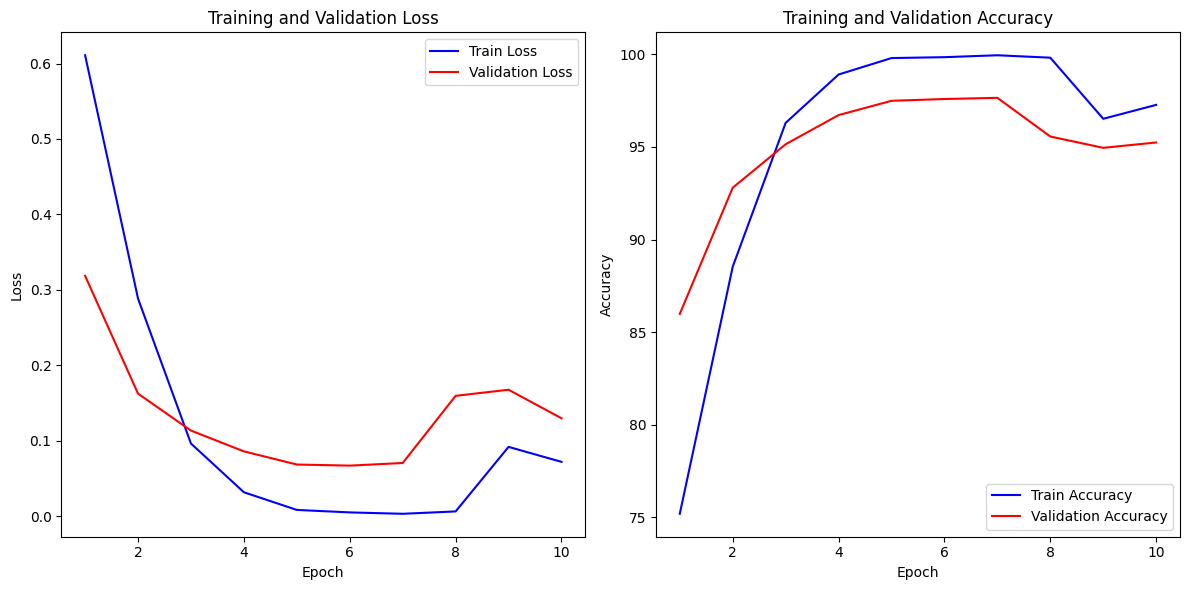

In [19]:
plot_from_history(Fsecondhistory)

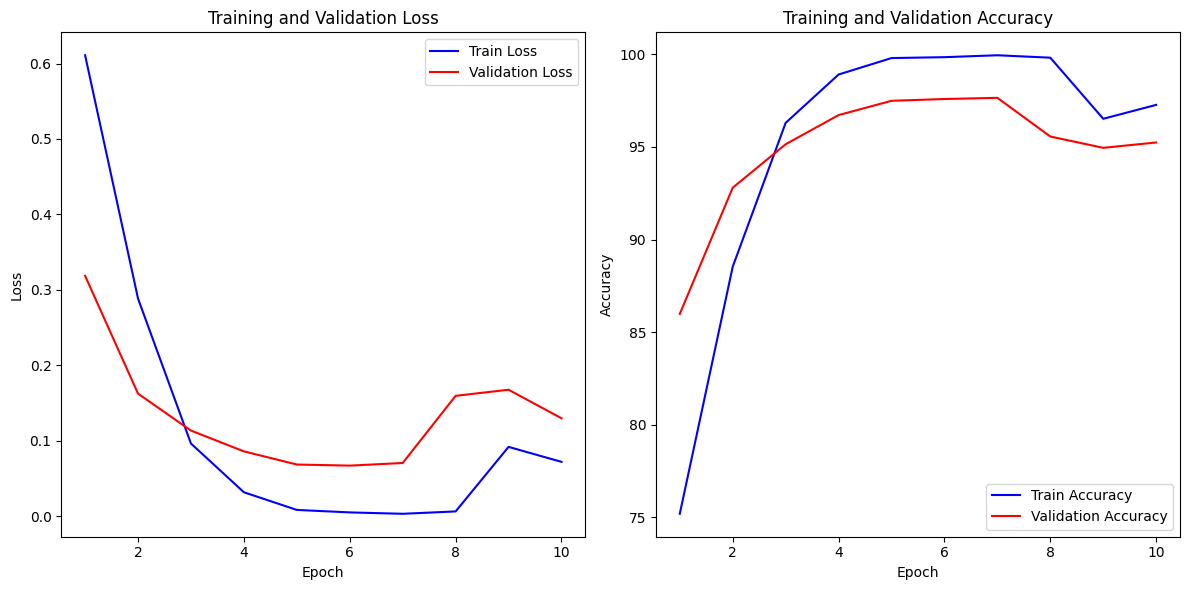

In [20]:
df = pd.DataFrame(Fsecondhistory)
df.to_csv('training_history/second_training_historyv4.csv', index=False)

history_df = pd.read_csv('training_history/second_training_historyv4.csv')

Fsecondhistory = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(Fsecondhistory)

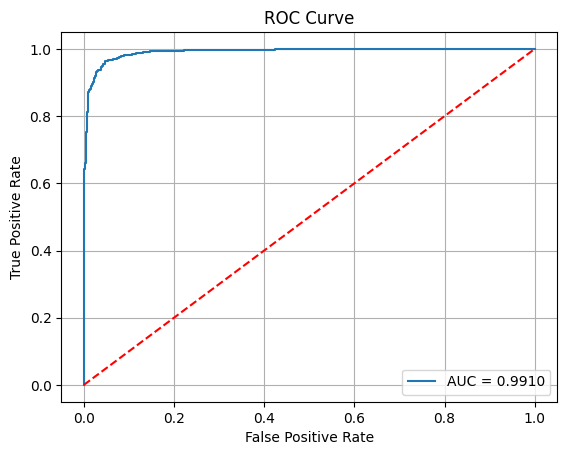

In [21]:
import pandas as pd

# Flatten data for CSV saving
Fsecondmetrics_flat = {
    "class_names": Fsecondmetrics["class_names"],
    "fpr": Fsecondmetrics["fpr"],
    "fnr": Fsecondmetrics["fnr"],
    "auc_roc": Fsecondmetrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
}
plot_roc_curve(Fsecondmetrics_flat)


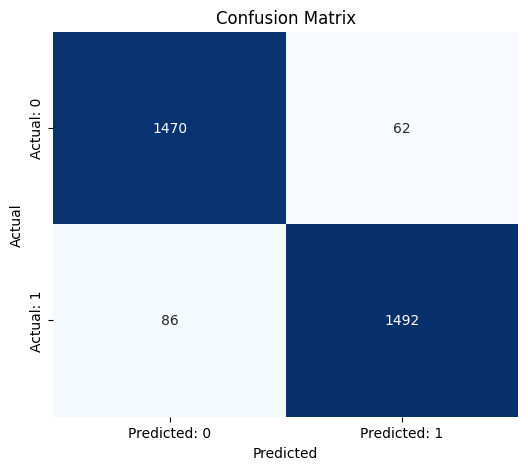

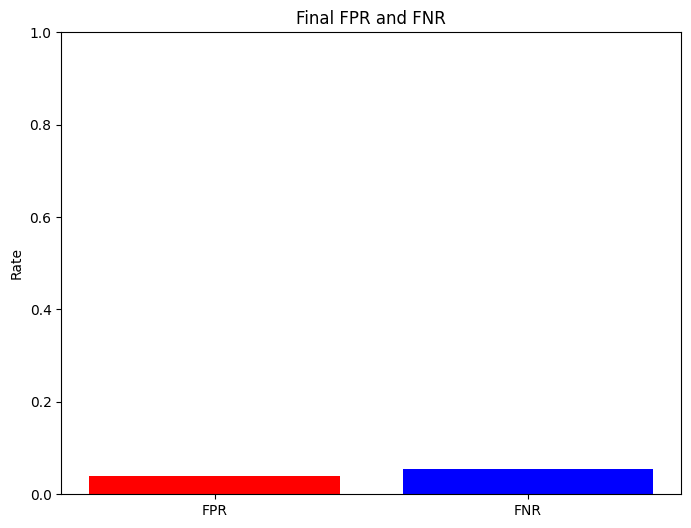

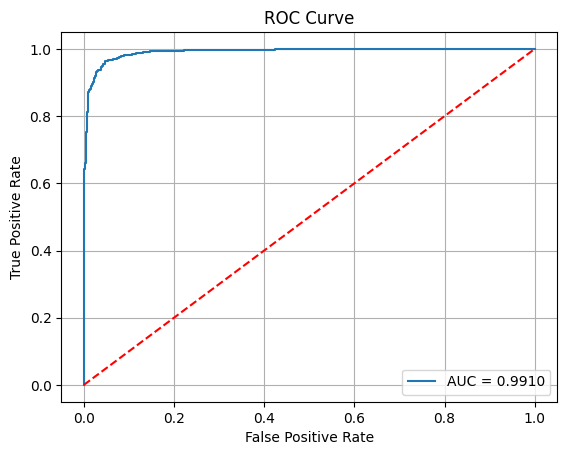

In [22]:

# # Save metrics to CSV
metrics_df = pd.DataFrame(Fsecondmetrics_flat)

metrics_df.to_csv('training_history/second_training_metricsv4.csv', index=False)


# Load the CSV file containing the final metrics
metrics_df = pd.read_csv('training_history/second_training_metricsv4.csv')

# Extract individual metrics
auc_score = metrics_df['auc_roc'][0]
fpr = metrics_df['fpr'][0]
fnr = metrics_df['fnr'][0]

# Extract confusion matrix (flattened form)
conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
tn, fp, fn, tp = conf_matrix

# Extract ROC curve data (flattened form)
roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
# Confusion Matrix heatmap
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot FPR and FNR
plt.figure(figsize=(8, 6))
plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
plt.ylabel('Rate')
plt.title('Final FPR and FNR')
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


### Save Model


In [23]:
torch.save(model, "Saved models/resnet_inception_fullmodel_croppedv4.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("Saved models/resnet_inception_fullmodel_croppedv4.pt")


### Import Model

In [24]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("Saved models/resnet_inception_fullmodel_croppedv4.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Appropriate


# RESNET X SVM MODEL


In [35]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Dataset path


# Dataset path
dataset_path = "./train"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load dataset with transformations
# dataset = ImageFolder(dataset_path, transform=transform)
# dataset_visual = ImageFolder(dataset_path, transform=transform_visual)

# # Extract class names
# class_names = sorted(os.listdir(dataset_path))  # Ensure consistent label ordering
# class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
# print("Class Names:", class_names)

# # Separate images by class
# image_paths = []
# labels = []
# for class_name in class_names:
#     class_folder = os.path.join(dataset_path, class_name)
#     if os.path.isdir(class_folder):
#         for img_path in glob.glob(f"{class_folder}/*.jpg"):
#             image_paths.append(img_path)
#             labels.append(class_to_idx[class_name])

# print("Total images found:", len(image_paths))

# # Separate images by class for balancing
# appropriate_indices = [i for i, label in enumerate(labels) if label == 0]
# inappropriate_indices = [i for i, label in enumerate(labels) if label == 1]

# # Check class sizes
# print(f"Appropriate class size: {len(appropriate_indices)}")
# print(f"Inappropriate class size: {len(inappropriate_indices)}")

# # Plot original class distribution
# plt.figure(figsize=(6, 4))
# sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
# plt.title("Original Class Distribution")
# plt.ylabel("Number of Images")
# plt.show()

# # Balance the dataset by undersampling the larger class
# if len(appropriate_indices) > len(inappropriate_indices):
#     appropriate_indices = random.sample(appropriate_indices, len(inappropriate_indices))

# # Merge the balanced indices and shuffle
# balanced_indices = appropriate_indices + inappropriate_indices
# balanced_indices = shuffle(balanced_indices)

# # Plot balanced class distribution
# plt.figure(figsize=(6, 4))
# sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
# plt.title("Balanced Class Distribution")
# plt.ylabel("Number of Images")
# plt.show()

# # Sample and show images from both classes
# def show_images(indices, title, num_images=5):
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#     for i, idx in enumerate(random.sample(indices, num_images)):
#         img, label = dataset_visual[idx]
#         axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
#         axes[i].set_title(class_names[label])
#         axes[i].axis("off")
#     plt.suptitle(title)
#     plt.show()

# # 🔹 **Display sample images**
# show_images(appropriate_indices, "Sample: Appropriate Content")
# show_images(inappropriate_indices, "Sample: Inappropriate Content")
# # Load balanced dataset
# balanced_image_paths = [image_paths[i] for i in balanced_indices]
# balanced_labels = [labels[i] for i in balanced_indices]

# images = []
# for img_path in tqdm(balanced_image_paths, desc="Loading balanced images"):
#     img = Image.open(img_path).convert("RGB")
#     img_tensor = transform(img)
#     images.append(img_tensor)

# images = torch.stack(images)
# labels = torch.tensor(balanced_labels)




# Define augmentations for training (Applied dynamically)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((224, 224)),               # Resize images to fit model input
    # transforms.RandomHorizontalFlip(),           # Apply random horizontal flip
    # transforms.RandomRotation(10),             # Rotate images randomly by ±10 degrees
    transforms.Lambda(lambda img: transforms.functional.hflip(img)),  # Always flip

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Augment
    transforms.ToTensor(),                       # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Define transformations for validation/testing (No augmentation)
val_test_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset without transformations for processing
dataset_raw = ImageFolder(dataset_path)
dataset_original = ImageFolder(dataset_path, transform=val_test_transform)  # No augmentation

# Extract class names and indices
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Separate images by class
image_paths = [path for path, _ in dataset_raw.samples]
labels = [label for _, label in dataset_raw.samples]

# Get class indices
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]

# Balance the dataset by undersampling the larger class
min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
appropriate_indices = random.sample(appropriate_indices, min_class_size)
inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# Merge balanced indices and shuffle
balanced_indices = appropriate_indices + inappropriate_indices
balanced_indices = shuffle(balanced_indices, random_state=42)

# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size  # Ensure total length matches

# Split the dataset
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets with respective transformations
dataset_train = Subset(ImageFolder(dataset_path, transform=train_transform), train_indices)
dataset_val = Subset(ImageFolder(dataset_path, transform=val_test_transform), val_indices)
dataset_test = Subset(ImageFolder(dataset_path, transform=val_test_transform), test_indices)

# Create DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Balanced Training Dataset Size: {len(dataset_train)}")
print(f"Balanced Validation Dataset Size: {len(dataset_val)}")
print(f"Balanced Test Dataset Size: {len(dataset_test)}")

# Load ResNet50 pre-trained model
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.eval()

for param in resnet.parameters():
    param.requires_grad = False

# for param in list(resnet.parameters())[-75:]:
#     param.requires_grad = True

# Move model and data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
# images = images.to(device)
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Keep layers up to the last conv layer

    def forward(self, x):
        x = self.features(x)  # Extract features
        return x
    
# WORKS EXACTLY THE SAME WITH NN.IDENTITY IF nn.Sequential(*list(base_model.children())[:-1]) , gap will be retained
base_model_resnet = ResNet50FeatureExtractor(models.resnet50(weights=ResNet50_Weights.DEFAULT))
base_model_resnet.eval()
base_model_resnet = base_model_resnet.to(device)




Directory found: ./train
Contents: ['Appropriate', 'Inappropriate']
Class Names: ['Appropriate', 'Inappropriate']
Balanced Training Dataset Size: 714
Balanced Validation Dataset Size: 153
Balanced Test Dataset Size: 153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3687146..2.13

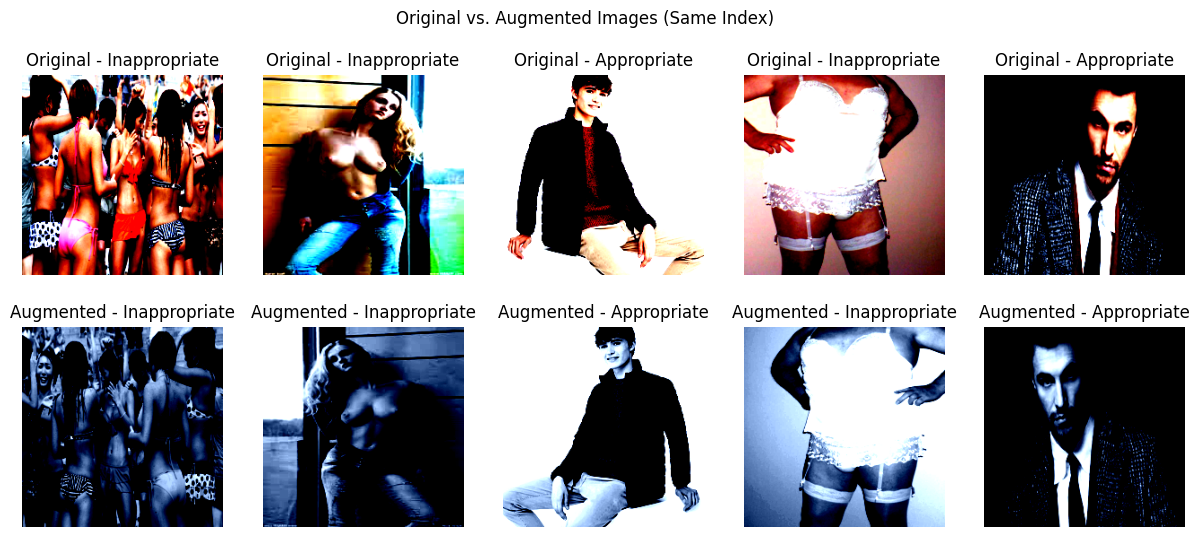

In [36]:
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset without augmentation to get original images
dataset_original = ImageFolder(dataset_path, transform=val_test_transform)  # No augmentation

# Function to show original vs. augmented images (same index)
def show_original_vs_augmented(dataset_original, dataset_augmented, subset_indices, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i, subset_idx in enumerate(subset_indices[:num_images]):  # Use the same indices
        # Get original image file path and label
        img_path, label = dataset_original.samples[subset_idx]  
        
        # Load image using PIL and apply transformation (No augmentation)
        img_original = Image.open(img_path).convert("RGB")
        img_original = val_test_transform(img_original)  # Apply transformation (no augmentation)
        img_original = img_original.permute(1, 2, 0).numpy()  # Convert to (H, W, C)

        # Get augmented image using the same index from dataset_train
        img_augmented, _ = dataset_augmented.dataset[subset_idx]  # Load from the original dataset
        img_augmented = img_augmented.permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original)
        axes[0, i].set_title(f"Original - {dataset_original.classes[label]}")
        axes[0, i].axis("off")

        # Display augmented
        axes[1, i].imshow(img_augmented)
        axes[1, i].set_title(f"Augmented - {dataset_original.classes[label]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Augmented Images (Same Index)")
    plt.show()

# Select random indices from the balanced dataset
random_indices = random.sample(balanced_indices, 5)

# Show images using the same indices
show_original_vs_augmented(dataset_original, dataset_train, random_indices)


In [2]:
features = []
labels_list = []

with torch.no_grad():
    for img_path, label in tqdm(zip(balanced_image_paths, balanced_labels), total=len(balanced_image_paths), desc="Extracting features"):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # Transform and add batch dimension
        feature = resnet(img_tensor).squeeze().cpu().numpy()  # Extract and convert feature
        features.append(feature)
        labels_list.append(label)  # Store labels in a list

features = np.array(features)
labels = np.array(labels_list)  # Convert labels to numpy array


Extracting features: 100%|██████████| 20736/20736 [07:34<00:00, 45.66it/s]


In [ ]:

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train SVM Classifier
print("Training SVM classifier...")
svm_classifier = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM classifier
y_pred = svm_classifier.predict(X_test)
y_prob = svm_classifier.predict_proba(X_test)[:, 1]  # Now we use predict_proba()

print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=class_names))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))





In [4]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names)

# Save classification report to a file
with open("SVM_first_classification_reportv2.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_test, y_pred)}\n") 


print(report)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

               precision    recall  f1-score   support

  Appropriate       0.91      0.91      0.91      2014
Inappropriate       0.92      0.92      0.92      2134

     accuracy                           0.92      4148
    macro avg       0.92      0.92      0.92      4148
 weighted avg       0.92      0.92      0.92      4148

Accuracy Score: 0.9158630665380907


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def fromfile_plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
def plot_feature_importance(svm_classifier, feature_names):
    if hasattr(svm_classifier, "coef_"):
        importance = np.abs(svm_classifier.coef_).flatten()
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(importance)), importance[sorted_idx], align="center")
        plt.xticks(range(len(importance)), np.array(feature_names)[sorted_idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title("Feature Importance in Linear SVM")
        plt.show()
    else:
        print("Feature importance is only available for linear SVMs.")


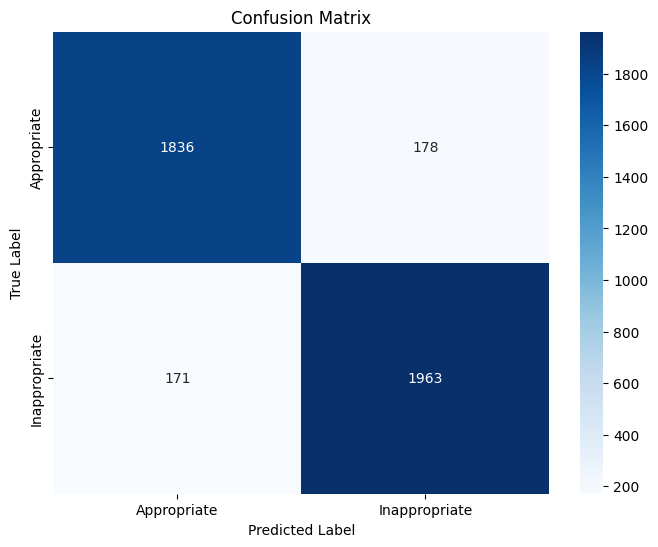

TN: 1836, FP: 178, FN: 171, TP: 1963


In [6]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)
plot_confusion_matrix(y_test, y_pred, class_names)
# Extract TN, FP, FN, TP

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print


False Positive Rate (FPR): 0.0884
False Negative Rate (FNR): 0.0801
AUC-ROC Score: 0.9756


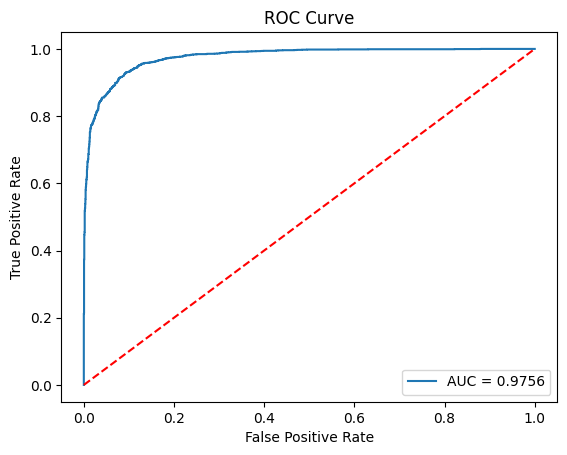

In [7]:

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Compute AUC-ROC using predict_proba()
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### second training

In [8]:
for param in list(resnet.parameters())[-75:]:
    param.requires_grad = True
    
for name, param in resnet.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")



conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

In [9]:
features2 = []
labels_list = []

with torch.no_grad():
    for img_path, label in tqdm(zip(balanced_image_paths, balanced_labels), total=len(balanced_image_paths), desc="Extracting features"):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # Transform and add batch dimension
        feature = resnet(img_tensor).squeeze().cpu().numpy()  # Extract and convert feature
        features2.append(feature)
        labels_list.append(label)  # Store labels in a list

features2 = np.array(features2)
labels2 = np.array(labels_list)  # Convert labels to numpy array
X_train, X_test, y_train, y_test = train_test_split(features2, labels2, test_size=0.2, random_state=42)


Extracting features: 100%|██████████| 20736/20736 [12:57<00:00, 26.66it/s]


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# 🔹 Standardize CNN features (important for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Define parameter grid for C values
param_grid = {'C': [0.01, 0.1, 1, 10]}

# 🔹 Perform Grid Search
grid_search = GridSearchCV(svm.SVC(kernel='linear', probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# 🔹 Get best hyperparameters
best_C = grid_search.best_params_['C']
print(f"Best C: {best_C}")

# 🔹 Train final SVM with best C
svm_classifier = svm.SVC(kernel='linear', C=best_C, probability=True, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# 🔹 Evaluate
y_pred = svm_classifier.predict(X_test_scaled)
y_prob = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=class_names))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))

print("Classification Report:")
# print(classification_report(y_test, y_pred, target_names=class_names))
# print("Accuracy Score:", accuracy_score(y_test, y_pred))


# Generate classification report
report = classification_report(y_test, y_pred, target_names=class_names)

# Save classification report to a file
with open("SVM_second_classification_reportv2.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracy_score(y_test, y_pred)}\n") 

print(report)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time= 5.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.8min
[CV] END ..............................................C=0.1; total time= 6.1min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.3min
[CV] END ..............................................C=0.1; total time= 5.8min
[CV] END ................................................C=1; total time= 6.0min
[CV] END ........................................

In [47]:
with open("HyperparamTuningSVM.txt", "r") as file:
    report = file.read()

print(report)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time= 5.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.9min
[CV] END .............................................C=0.01; total time= 5.0min
[CV] END .............................................C=0.01; total time= 4.8min
[CV] END ..............................................C=0.1; total time= 6.1min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.4min
[CV] END ..............................................C=0.1; total time= 6.3min
[CV] END ..............................................C=0.1; total time= 5.8min
[CV] END ................................................C=1; total time= 6.0min
[CV] END ........................................

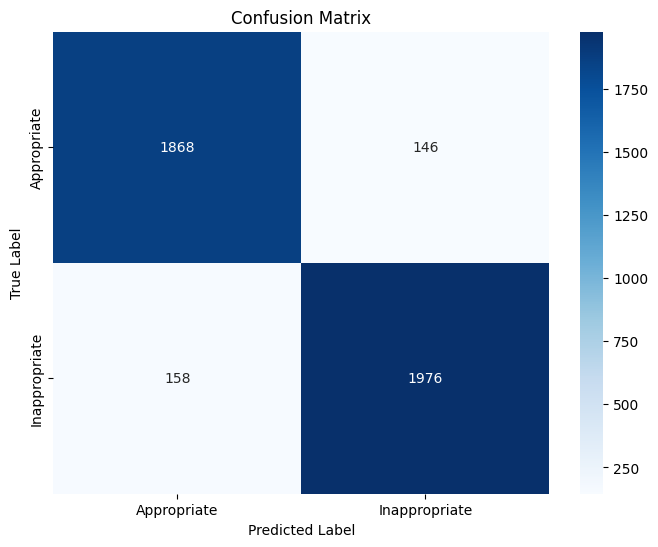

TN: 1868, FP: 146, FN: 158, TP: 1976


In [11]:
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, roc_curve
)
plot_confusion_matrix(y_test, y_pred, class_names)
# Extract TN, FP, FN, TP

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print


False Positive Rate (FPR): 0.0725
False Negative Rate (FNR): 0.0740
AUC-ROC Score: 0.9770


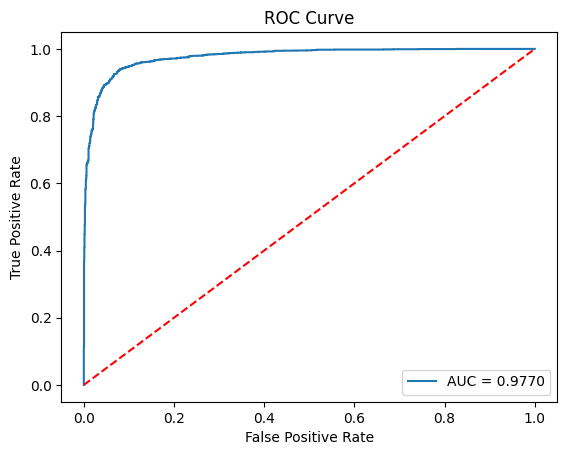

In [12]:

# Compute FPR and FNR
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Compute AUC-ROC using predict_proba()
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### save training results


Metrics saved successfully.


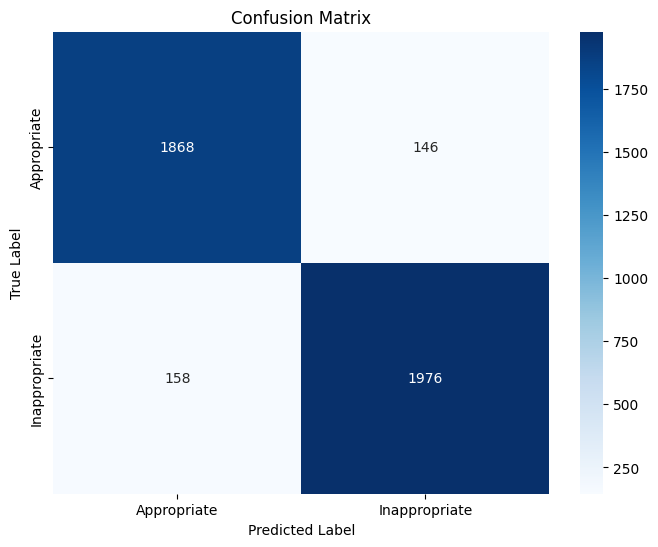

Accuracy: 0.9267
False Positive Rate (FPR): 0.0725
False Negative Rate (FNR): 0.0740
AUC-ROC Score: 0.9770


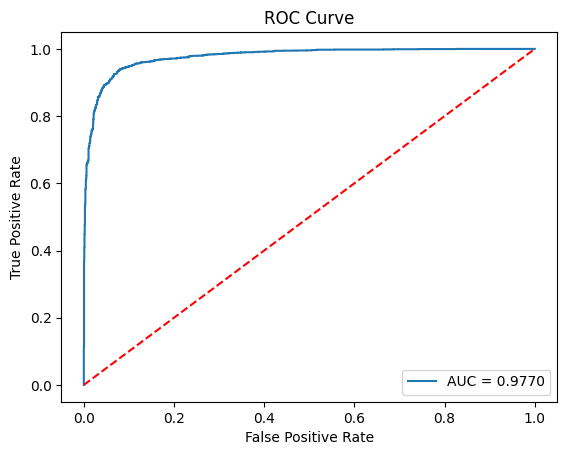

In [13]:
import pickle

metrics = {
    "class_names": class_names,
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "fpr": fpr,
    "fnr": fnr,
    "auc_roc": auc_score,
    "roc_curve": (fpr_vals, tpr_vals)  # Save ROC data for later plotting
}

# Save as a NumPy file
np.savez("Saved models/second_svm_metrics.npz", **metrics)

# Save using Pickle (optional, for structured data)
# with open("svm_metrics.pkl", "wb") as f:
#     pickle.dump(metrics, f)

print("Metrics saved successfully.")
# Load metrics from NumPy file
loaded_data = np.load("Saved models/second_svm_metrics.npz", allow_pickle=True)

# Extract metrics
conf_matrix = loaded_data["confusion_matrix"]
accuracy = loaded_data["accuracy"]
fpr = loaded_data["fpr"]
fnr = loaded_data["fnr"]
auc_score = loaded_data["auc_roc"]
fpr_vals, tpr_vals = loaded_data["roc_curve"]


# Plot the confusion matrix
fromfile_plot_confusion_matrix(conf_matrix, class_names)
print(f"Accuracy: {accuracy:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Save RESNET X SVM

In [14]:
torch.save(resnet, "Saved models/svm/fullresnetextractor.pth")

import joblib

svm_save_path = 'Saved models/svm'
svm_model_path = os.path.join(svm_save_path, 'fulltorch_svm.pkl')
joblib.dump(svm_classifier, svm_model_path)

['Saved models/svm\\fulltorch_svm.pkl']

### Import Model

In [15]:
import os
import joblib
import torch
from torchvision import transforms
from PIL import Image

class_names = ['Appropriate', 'Inappropriate']

# Load the ResNet feature extractor
load_ex = torch.load('Saved models/svm/fullresnetextractor.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_ex.to(device)
print("Feature extractor loaded.")

# Load the SVM model
svm_model_path = os.path.join('Saved models/svm', 'fulltorch_svm.pkl')
load_svm = joblib.load(svm_model_path)
print("SVM classifier loaded.")
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0).to(device)

 
    
    return img_tensor_resnet

def predict_image(img_path):
    """
    Predict the class of an image using the saved ResNet-based feature extractor and SVM classifier.

    Args:
        img_path (str): Path to the image file.

    Returns:
        str: Predicted class name.
    """
    img = Image.open(img_path).convert("RGB")
    img_tensor = resnet_transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    load_ex.eval()  # Ensure the model is in evaluation mode
    
    with torch.no_grad():
        feature_map = load_ex(img_tensor)  
        flattened_features = feature_map.squeeze().cpu().numpy().reshape(1, -1)  
    prediction = load_svm.predict(flattened_features)  # Predict using the trained SVM classifier
    return class_names[prediction[0]]


print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

C:\Users\user\AppData\Local\Temp\ipykernel_16692\662776534.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_ex = torch.load('Saved models/svm/fullresnetextractor.pt

Feature extractor loaded.
SVM classifier loaded.
['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Inappropriate
Predicted Class for ./DARKNET/test1.jpg: Inappropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Inappropriate
